In [1]:
import matplotlib.pyplot as plt
from numpy import genfromtxt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.ticker as mticker
import os

headers = ["event_id", "track_id", "type", "x", "y", "z", "delta_E", "process"]


def proc_file(energy):
    filepath = os.path.join(os.getcwd(), f"spectrum/{energy}/proc.txt")
    with open(f'spectrum/{energy}/log.txt', 'r') as f:
        with open(filepath, 'w') as new_f:
            for i, line in enumerate(f):
                if "ProcName" in line:
                    new_f.write(line)
                    

# generate process name files
for i in os.listdir("spectrum/"):
    if os.path.isfile(f"spectrum/{i}/log.txt"):
        proc_file(i)

def proc_list(energy, my_data):
    proc = []
    with open(f'spectrum/{energy}/proc.txt', 'r') as f:
        for i, line in enumerate(f):
            #print(my_data[i], line.split()[3])
            proc.append(line.split()[3])
            if i > 5:
                break
    return proc



In [2]:
## below is from prev scripts
def search_for_thing(column, search_param, my_data):
    electron_array = []
    for i in range(len(my_data.T[0])):
        if my_data.T[column][i] == search_param:
            electron_array.append(my_data[i])
    if len(electron_array) == 0:
        print("Couldn't find anything with", headers[column], f"= {search_param}")
    else: 
        print(headers[column], f" = {search_param}")
    return np.array(electron_array)


def find_electrons(my_data):
    arr = search_for_thing(2, 1, my_data) # look for electrons
    plt.scatter(arr.T[0], arr.T[1])
    plt.xlabel("event_id")
    plt.ylabel("track_id")
    
def integrate_over(event_num, track_num, data, param = 6):
    integrate = 0
    for i in range(len(data)):
        if data.T[0][i] == event_num and data.T[1][i] == track_num:
            integrate = integrate + data.T[param][i]
    return [event_num, track_num, integrate]

def integrate_over(event_num, track_num, data, param = 6, subtract = None):
    integrate = 0
    for i in range(len(data)):
        if data.T[0][i] == event_num and data.T[1][i] == track_num:
            if not subtract:
                integrate = integrate + data.T[param][i]
            if subtract:
                ## Need to check case where next track occurs but same event
                if data.T[0][i - 1] == event_num and data.T[1][i - 1] == track_num:
                    integrate = integrate + data.T[param][i] - data.T[param][i - 1]
                else:
                    integrate = integrate + 0
    return [event_num, track_num, integrate]
    
    
def track_length_and_energy(my_data):
    # integrate energy data over track_id, event_id
    integrated_energy_by_event = []
    integrated_length_by_event_x = []
    integrated_length_by_event_y = []
    integrated_length_by_event_z = []
    for event in range(0, 20):
        for track in range(0, 20):
            integrated_energy_by_event.append(integrate_over(event, track, my_data))
            # get track lengths, `subtract = 1` shows delta track length
            integrated_length_by_event_x.append(integrate_over(event, track, my_data, param = 3, subtract = 1))
            integrated_length_by_event_y.append(integrate_over(event, track, my_data, param = 4, subtract = 1))
            integrated_length_by_event_z.append(integrate_over(event, track, my_data, param = 5, subtract = 1))

    ## convert to np arrays
    integrated_energy_by_event = np.array(integrated_energy_by_event)
    integrated_length_by_event_x = np.array(integrated_length_by_event_x)
    integrated_length_by_event_y = np.array(integrated_length_by_event_y)
    integrated_length_by_event_z = np.array(integrated_length_by_event_z)

    ## find magnitude of track lengths
    integrated_length_by_event = np.sqrt((integrated_length_by_event_x.T[2])**2 + (integrated_length_by_event_y.T[2])**2 + (integrated_length_by_event_z.T[2])**2)
    return integrated_length_by_event, integrated_energy_by_event




In [3]:
def search_for_proc(search_param, proc_list, my_data):
    proc_name = []
    for i in range(len(proc_list)):
        #print(proc_list[i])
        if proc_list[i] == search_param:
            proc_name.append(my_data[i])
            #print(proc_list[i])
    if len(proc_name) == 0:
        print("Couldn't find anything with", "process", f"= {search_param}")
    else: 
        print("ProcName", f"= {search_param}")
    return np.array(proc_name)

Couldn't find anything with process = eIoni


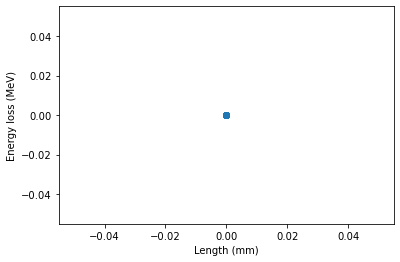

In [4]:
my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')

proc = proc_list(6283.8, my_data)

eioni = search_for_proc("eIoni", proc, my_data)

length, energy = track_length_and_energy(eioni)

plt.scatter(length, energy.T[2])
plt.xlabel("Length (mm)")
plt.ylabel("Energy loss (MeV)")
plt.show()

In [5]:
import pandas as pd
import itertools

my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')
proc = proc_list(6283.8, my_data)
eioni = search_for_proc("Transportation", proc, my_data)

print(headers)
print(eioni)
  
# creating a list of index names

track_event = []
pos_array = []
letterid = ["a", "b", "c"]

for i, val in enumerate(eioni):
    ide = str(letterid[i]) + str(int(val[0])) + str(int(val[1]))
    track_event.append(ide)
    pos_array.append(val[3:6])

pos_array = np.array(pos_array).T


pos_array.T[0] = [0.0, 0.0, 1010.0]
# creating a list of column names
column_values = ['x', 'y', 'z']
# creating the dataframe
df = pd.DataFrame(data = pos_array, 
                  index = column_values, 
                  columns = track_event)
  

ProcName = Transportation
['event_id', 'track_id', 'type', 'x', 'y', 'z', 'delta_E', 'process']
[[   0.    1.    0.    0.    0. 1000.    0.    0.]
 [   0.    1.    0.    0.    0. 1000.    0.    0.]
 [   0.    1.    0.    0.    0. 1000.    0.    0.]]


In [6]:
def subtractions_of_combinations(df):
    # Extract all the combinations
    combinations = list(itertools.permutations(df.columns, 2)) 
    # Calculate the two possible subtractions for each combination
    new_df = pd.DataFrame()
    for a, b in combinations:
        new_df[f'{a}-{b}'] = df[a] - df[b]
    return new_df

newdf = subtractions_of_combinations(df)

newdf

,a01-b01,a01-c01,b01-a01,b01-c01,c01-a01,c01-b01
x,0.0,0.0,0.0,0.0,0.0,0.0
y,0.0,0.0,0.0,0.0,0.0,0.0
z,10.0,10.0,-10.0,0.0,-10.0,0.0


In [7]:
df

,a01,b01,c01
x,0.0,0.0,0.0
y,0.0,0.0,0.0
z,1010.0,1000.0,1000.0
